<style type="text/css">
.reveal h1 {
    font-size: 2em;
}
</style>

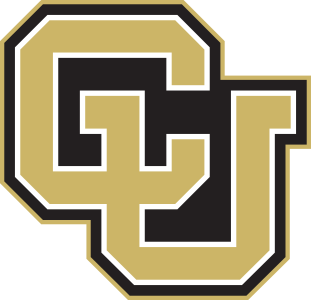

# Lecture 02, hands-on: Building a classifier
*(CPBS 7602: Introduction to Big Data in the Biomedical Sciences)*

By __Milton Pividori__<br>Department of Biomedical Informatics<br>University of Colorado Anschutz Medical Campus

# Goals
* Identifying the components of a supervised learning problem.
* Basic understanding of tree-based algorithms.
* Basic overview of overfitting.

# Review: Regression vs. Classification

Consider a training dataset $\mathcal{D} = \{(x^{(1)}, y^{(1)}), (x^{(2)}, y^{(2)}), \ldots, (x^{(n)}, y^{(n)})\}$.

We distinguish between supervised learning problems depending on the targets $y^{(i)}$:

1. **Regression**: The target space is continuous: $\mathcal{Y} \subseteq \mathbb{R}$.
2. **Classification**: The target space is discrete: $\mathcal{Y} = \{y_1, y_2, \ldots, y_K\}$. <br>
   <span style='color: gray'>Each of the $K$ discrete values corresponds to a *class* that we want to predict</span>

## Binary Classification

An important special case of classification is when the number of classes $K=2$.

In this case, we have an instance of a *binary classification* problem.

# The Dataset

## An Example: Classifying Iris Flowers

Our running example for classification problems will be the **iris flower dataset**.

This is a classic dataset originally published by [R. A. Fisher](https://en.wikipedia.org/wiki/Ronald_Fisher) in 1936.

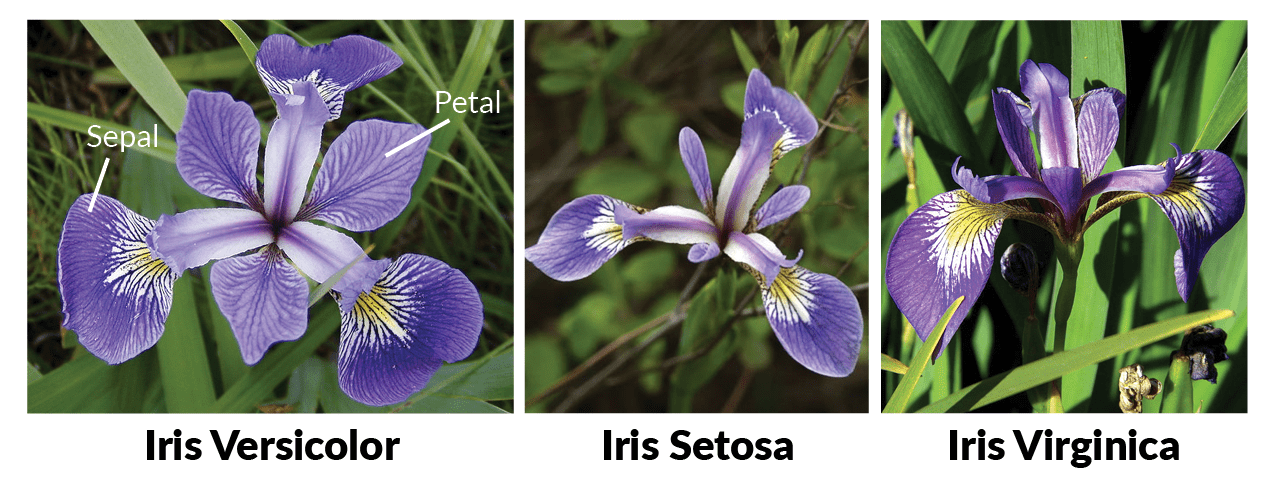

Let's import the dataset from `sklearn`.

In [1]:
import warnings

warnings.filterwarnings("ignore")
from sklearn import datasets

iris = datasets.load_iris(as_frame=True)

In [2]:
iris_X, iris_y = iris.data, iris.target

In [4]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

## Exercise 1: Analyze the Dataset

Look at the variables with the Iris flowers data above and answer the **questions** below.

*Tip:* running `print(iris.DESCR)` will give you a description of the dataset.

### Question 1

What is the value of $n$ for this dataset? What does $n$ represent?

_Answer_: n=150, the number of instances in the dataset

### Question 2

What is the value of $d$? What is $d$?

_Answer_: d=4, the number of features per instance

### Question 3

1. Which variable has the inputs? Which variable has the targets?
1. For $i=3$, answer:
   1. What does $x^{(i)}$ look like?
   2. And $y^{(i)}$?

In [ ]:
iris_X has inputs, iris_y has targets

In [5]:
iris_X.iloc[3]

sepal length (cm)    4.6
sepal width (cm)     3.1
petal length (cm)    1.5
petal width (cm)     0.2
Name: 3, dtype: float64

In [6]:
print(iris_y[3])

0


### Question 4

Given the type of the targets, what kind of supervised learning approach should we use?
1. Is this a binary classification problem?

_Answer_: classification. not binary b/c 3 classes

# The Learning Algorithm

## Decision Trees

### The UCI Diabetes Dataset

To explain what a decision tree is, we are going to use the UCI diabetes dataset that we worked with before.

Let's start by loading this dataset.

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [12, 4]
from sklearn import datasets

# Load the diabetes dataset
diabetes = datasets.load_diabetes(as_frame=True, scaled=False)
print(diabetes.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

:Number of Instances: 442

:Number of Attributes: First 10 columns are numeric predictive values

:Target: Column 11 is a quantitative measure of disease progression one year after baseline

:Attribute Information:
    - age     age in years
    - sex
    - bmi     body mass index
    - bp      average blood pressure
    - s1      tc, total serum cholesterol
    - s2      ldl, low-density lipoproteins
    - s3      hdl, high-density lipoproteins
    - s4      tch, total cholesterol / HDL
    - s5      ltg, possibly log of serum triglycerides level
    - s6      glu, blood sugar level

Note: Each of these 10 feature variables have bee

We can also look at the data directly.

In [8]:
# Load the diabetes dataset
diabetes_X, diabetes_y = diabetes.data, diabetes.target

# create a binary risk feature
diabetes_y_risk = diabetes_y.copy()
diabetes_y_risk[:] = 0
diabetes_y_risk[diabetes_y > 150] = 1

# Print part of the dataset
diabetes_X.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,59.0,2.0,32.1,101.0,157.0,93.2,38.0,4.0,4.8598,87.0
1,48.0,1.0,21.6,87.0,183.0,103.2,70.0,3.0,3.8918,69.0
2,72.0,2.0,30.5,93.0,156.0,93.6,41.0,4.0,4.6728,85.0
3,24.0,1.0,25.3,84.0,198.0,131.4,40.0,5.0,4.8903,89.0
4,50.0,1.0,23.0,101.0,192.0,125.4,52.0,4.0,4.2905,80.0


In [9]:
# Print the binary target
diabetes_y_risk.head()

0    1.0
1    0.0
2    0.0
3    1.0
4    0.0
Name: target, dtype: float64

### Decision Trees: Intuition

Decision trees are machine learning models that mimic how a human would approach this problem.
1. We start by picking a feature (e.g., age).
2. Then we *branch* on the feature based on its value (e.g., age > 65?).
3. We select and branch on one or more features (e.g., is it a man?).
4. Then we return an output that depends on all the features we've seen (e.g., a man over 65).

### Decision Trees: Example

Let's first see an example with the diabetes dataset.

We will train a decision tree using its implementation in `sklearn`.

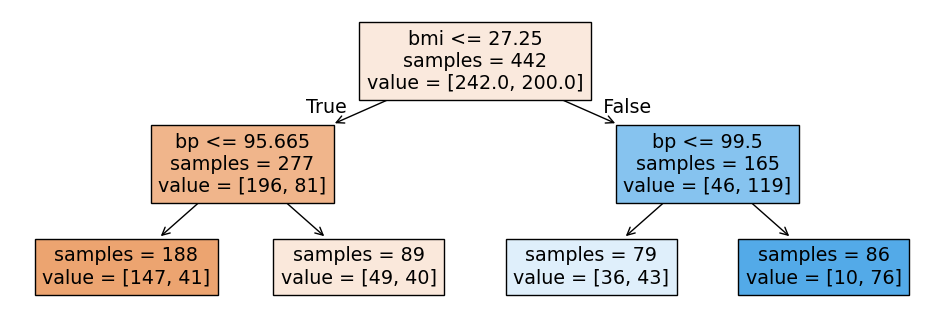

In [10]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

# create and fit the model
clf = DecisionTreeClassifier(max_depth=2)
clf.fit(diabetes_X.iloc[:, :4], diabetes_y_risk)

# visualize the model
plot_tree(clf, feature_names=diabetes_X.columns[:4], impurity=False, filled=True)
print("")

### Decision Rules

Let's now define a decision tree a bit more formally.
- A decision rule $r : \mathcal{X} \to \{\text{true}, \text{false}\}$ is a partition of the feature space into two disjoint regions, e.g.:
$$ r(x) = \begin{cases}\text{true} & \text{if } x_\text{bmi} \leq 27.25 \\ \text{false} & \text{if } x_\text{bmi} > 27.25 \end{cases} $$
- Normally, a rule applies to only one feature or attribute $x_j$ of $x$.
- If $x_j$ is continuous, the rule normally separates inputs $x_j$ into disjoint intervals $(-\infty, c], (c, \infty)$.

### Decision Trees: Definition

A decision tree is a (usually binary) tree, where:
- Each internal node $n$ corresponds to a rule $r_n$.
- The $j$-th edge out of $n$ is associated with a rule value $v_j$, and we follow the $j$-th edge if $r_n(x)=v_j$.
- Each leaf node $l$ contains a prediction $f(x)$.
- Given input $x$, we start at the root, apply its rule, follow the edge that corresponds to the outcome, and repeat recursively.

## Exercise 2: Implement a Decision Tree Classifier

Now, let's train a Decision Tree on the Iris flowers dataset!
**IMPORTANT**: use only the first two features: sepal length and sepal width.

But first, let's visualize our data:

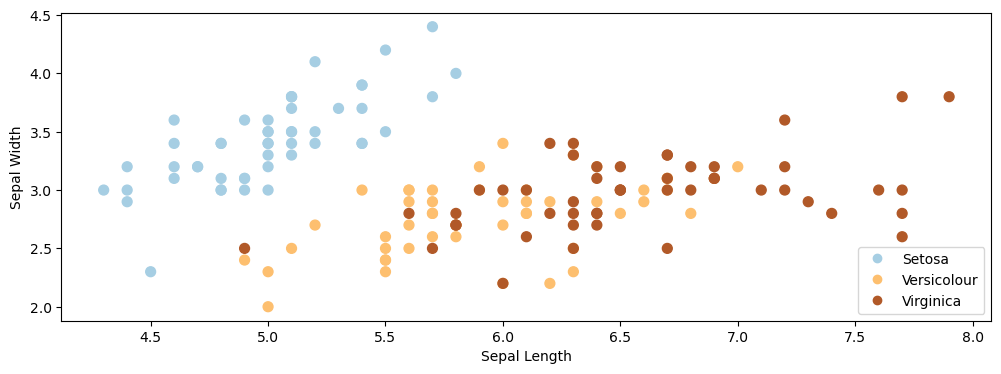

In [11]:
# Plot the training points
p1 = plt.scatter(
    iris_X.iloc[:, 0], iris_X.iloc[:, 1], c=iris_y, s=50, cmap=plt.cm.Paired
)
plt.xlabel("Sepal Length")
plt.ylabel("Sepal Width")
plt.legend(
    handles=p1.legend_elements()[0],
    labels=["Setosa", "Versicolour", "Virginica"],
    loc="lower right",
)

Ok. Now, let's implement and train our Decision Tree classifier using the Iris flowers dataset.
Remember to check the documentation of the [`DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).

In [12]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

decision_tree_classifier = DecisionTreeClassifier(max_depth = None)
decision_tree_classifier.fit(iris_X.iloc[:, :2], iris_y)






DecisionTreeClassifier()

**Question:** Use your trained model to predict the same data used for training. How is it performing?

*Tip:* You can compare the model prediction with the true labels using the [accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score), although [there are many metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics).

In [13]:
# prediction 
decision_tree_classifier.predict(iris_X.iloc[:, :2])


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 1])

## Exercise 3: Understand Decision Boundaries

Use the [`DecisionBoundaryDisplay`](https://scikit-learn.org/dev/modules/generated/sklearn.inspection.DecisionBoundaryDisplay.html) class from scikit-learn to analyze how the classifier you built performed.

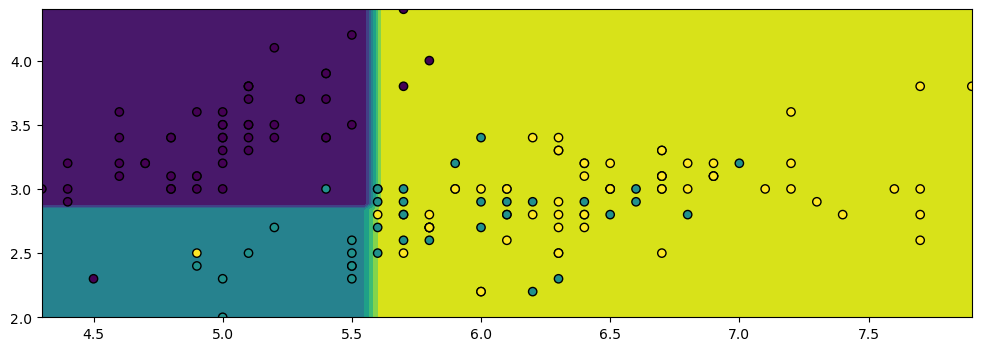

In [47]:
from sklearn.inspection import DecisionBoundaryDisplay
import numpy as np

feature_1, feature_2 = np.meshgrid(
    np.linspace(iris_X.iloc[:, 0].min(), iris_X.iloc[:, 0].max()),
    np.linspace(iris_X.iloc[:, 1].min(), iris_X.iloc[:, 1].max())
)
grid = np.vstack([feature_1.ravel(), feature_2.ravel()]).T
y_pred = np.reshape(decision_tree_classifier.predict(grid), feature_1.shape)
display = DecisionBoundaryDisplay(
    xx0=feature_1, xx1=feature_2, response=y_pred
)

display.plot()

display.ax_.scatter(
    iris_X.iloc[:, 0], iris_X.iloc[:, 1], c=iris.target, edgecolor="black"
)
plt.show()

**Question:** Do you see a problem with the decision boundaries above? Avoid searching on the Internet and instead explain it with your own words.

_Answer_: overfitting

## Exercise 4: Understand Decision Rules

Use the [`plot_tree`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html) function to visualize the tree of your classifier.

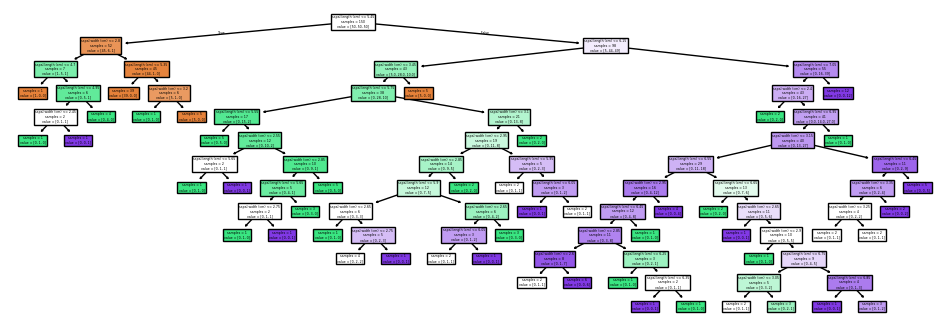

In [15]:
# visualize the model
plot_tree(decision_tree_classifier, feature_names=iris_X.columns[:2], impurity=False, filled=True)
print("")

**Question:** Can you match points from the decision boundary above to the tree visualized here? Mention an example.

_Answer_: add answer

## Exercise 5: Properly split data into training and testing sets

Go to lecture 01, where we trained an MLP Classifier on handwritten digits. There, we used the function `train_test_split` from sklearn to split the data into train and test sets. Take that code and apply it here with Decision Trees and the Iris dataset. Play with the input features (first two vs all of them, etc) and the `test_size` parameter of function `train_test_split`.

**Questions**:

1. From the classifier perspective, what's the difference between a "training" and a "test" set?
1. What is the performance of your classifier on the test set? What happened?

In [53]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    iris_X.iloc[:, :2],
    iris_y,
    test_size = 0.2
)


In [54]:
X_train.head()

,sepal length (cm),sepal width (cm)
100,6.3,3.3
39,5.1,3.4
140,6.7,3.1
74,6.4,2.9
4,5.0,3.6


In [55]:
X_test.head()

,sepal length (cm),sepal width (cm)
101,5.8,2.7
71,6.1,2.8
9,4.9,3.1
19,5.1,3.8
87,6.3,2.3


In [57]:
decision_tree_classifier = DecisionTreeClassifier(max_depth = 3)
decision_tree_classifier.fit(X_train, y_train)

# prediction 
decision_tree_classifier.predict(X_test)

array([1, 1, 0, 0, 2, 2, 1, 2, 0, 1, 2, 0, 2, 1, 0, 0, 2, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 2, 2, 2, 1])

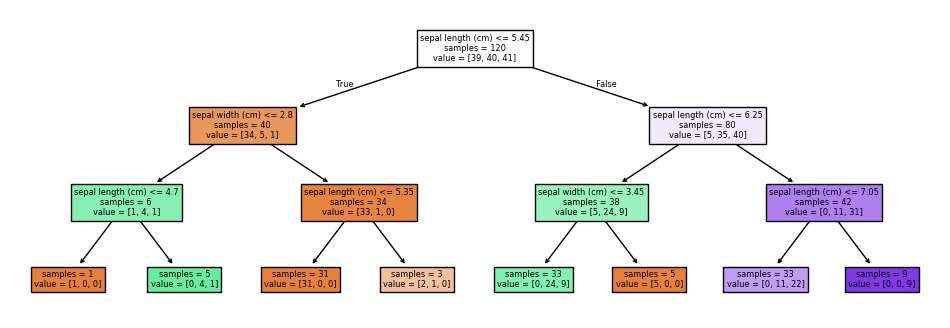

In [58]:
# visualize the model
plot_tree(decision_tree_classifier, feature_names=iris_X.columns[:2], impurity=False, filled=True)
print("")

## Exercise 6: Analyze the Learning Algorithm

Based on your code in Exercise 2, and using your own words, answer the following questions:
- What is the type of the ML approach?
- What is the model class?
- What is the objective function? Can we change the objective function for this model class?
- What is the optimizer?

_Answer_: supervised learning, specifically classification. model class is decision tree. objective function is default Gini index from scikit learn, although can be changed. 